# Morphological Operations

## Initialization

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from matplotlib.colors import NoNorm

In [2]:
# convenience function that estimates the difference between 2 images
def diffscore(img1, img2):
    return np.sum(abs(img1-img2))

# convenience function to draw 1 image - no typing 4 lines anymore
def display(img):
    plt.figure()
    plt.axis("off")
    if len(img.shape) == 2:
        plt.imshow(img,cmap='gray',norm=NoNorm())
    elif img.shape[2] ==1:
        plt.imshow(img, cmap='gray', norm=NoNorm())
        # this ensures plt doesn't treat our grayscale array as a messed-up 3-channel image
    else:
        plt.imshow(img)
    plt.show()

## Basic operations

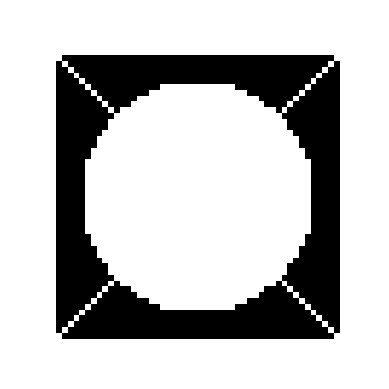

In [3]:
is_in_circle = lambda x,y: True if y**2+x**2<400 else False
is_edge = lambda x,y: True if abs(x)>24 or abs(y)>24 else False
is_diag = lambda x,y: True if abs(x)==abs(y) else False
select_color = lambda x,y: 255 if (is_edge(x,y) or is_in_circle(x,y) or is_diag(x,y)) else 0
# do not write actual code this way if there is any purpose other than having fun to it

blob = np.array([[select_color(x,y) for y in range(-32,32)] for x in range(-32,32)]).astype(np.uint8)
display(blob)

The two most basic morphological operations we have are dilation and erosion. Simply put, dilation expands the light/"True" regions and erosion, well, erodes them. Otherwise, it is just a matter of adding and subtracting masks.

Most of the time in image processing, we can equate the dilation and erosion operations to statistical max and min filters respectively...

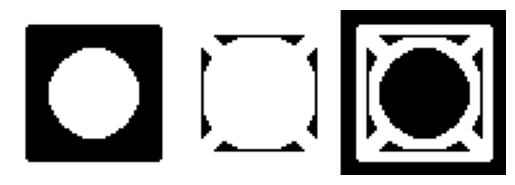

In [4]:
eroded = cv2.erode(blob, np.full((5,5),1))
dilated = cv2.dilate(blob, np.full((5,5),1))
display(np.concatenate([eroded, dilated, dilated-eroded], axis=1))

...with the caveat that the set we erode/dilate by might not be rectangular.

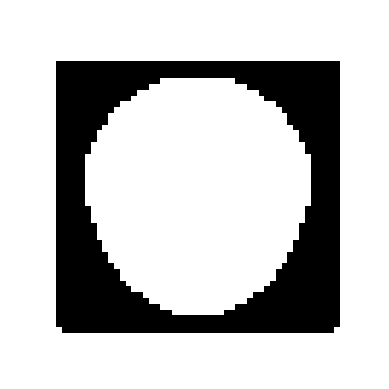

In [5]:
pike_kernel = np.array([[0,0,1,0,0],
                        [0,0,1,0,0],
                        [0,0,1,0,0],
                        [0,1,1,1,0],
                        [0,1,1,1,0],
                        [0,1,1,1,0],
                        [1,1,1,1,1]]).astype(np.uint8)

line_kernel = np.concatenate([np.full((9,1),1),
                              np.zeros((9,7)),
                              np.full((9,1),1)],axis=1).astype(np.uint8)

stretched = cv2.dilate(eroded, pike_kernel)
display(stretched)

#### Variable mask erosion/dilation (20 points)
Implement a method that mimics the dilation/erosion methods, including the ability to use a variable kernel. You can copy the apply_filter and some statistical filters from Practical 6, and modify them to add this capability. Confirm that your result is the same as above.

In [6]:
def apply_filter(img, ffunc, sx=3, sy=3, kernel = None):
    height, width, channels = img.shape
    cx = sx//2
    cy = sy//2
    img = np.concatenate([np.zeros((cx+1, width,channels)),img,np.zeros((cx+1, width, channels))], axis=0)
    img = np.concatenate([np.zeros((height+2*cx+2, cy+1,channels)),img,np.zeros((height+2*cx+2, cy+1, channels))], axis=1)
    out = img.copy()
    for x in range(cx+1, height+1+cx):
        for y in range(cy+1, width+1+cy):
            window = img[x-cx:x+cx+1, y-cy:y+cy+1,:]
            out[x][y] = ffunc(window, kernel)
    return out[cx+1:height+1+cx, cy+1:width+1+cy,:]

def max_filter(region_raw, kernel):
    height, width, channels = region_raw.shape
    region = region_raw
    if not isinstance (kernel,  type(None)):
        region = np.where(kernel, region_raw, 0)
    out = [0]*channels
    for c in range (channels):
        out[c] = np.max(region[:,:,c])
    return out

def min_filter(region_raw, kernel):
    height, width, channels = region_raw.shape
    region = region_raw
    if not isinstance (kernel,  type(None)):
        region = np.where(kernel, region_raw, 255)
    out = [0]*channels
    for c in range (channels):
        out[c] = np.min(region[:,:,c])
    return out

## Masks
In the previous practical, we saw how to threshold images based on color. Let us actually do something with the masks obtained by thresholding.

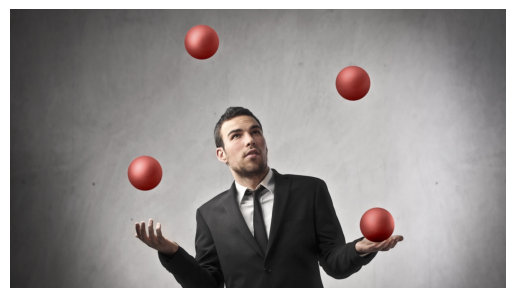

In [7]:
src = cv2.cvtColor(cv2.imread("balls.jpg"), cv2.COLOR_BGR2RGB)
display(src)

#### Where? (10 points)
Threshold out every red ball. This time, also use dilation/erosion on the mask to get as close to the real shapes as possible.

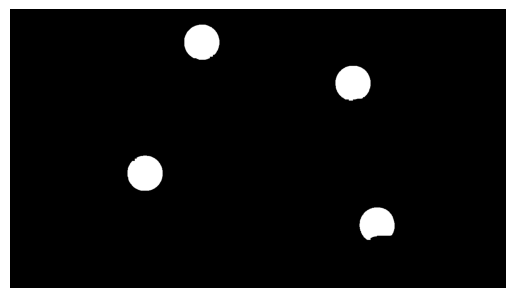

In [8]:
src_hsv = cv2.cvtColor(src, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(src_hsv, (0,100,70), (5,255,255))

mask = cv2.erode(mask, np.full((7,7),1))
mask = cv2.dilate(mask, np.full((29,29),1))
mask = cv2.erode(mask, np.full((21,21),1))

# mask = cv2.inRange(src_hsv, (0,100,00), (3,255,255))
# mask = cv2.erode(mask, np.full((7,7),1))
# mask = cv2.dilate(mask, np.full((33,33),1))
# mask = cv2.erode(mask, np.full((25,2),1))

display (mask)

#### Value changing under mask (12 points)
Turn the balls a different color. Ideally, preserve internal tones (hue differences on the balls)

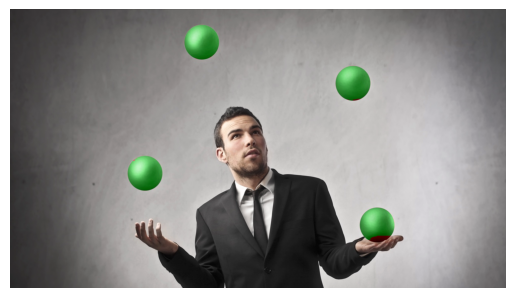

In [9]:
hue_new = np.where(mask, src_hsv[:,:,0]+60, src_hsv[:,:,0])
src_green = src_hsv.copy()
src_green[:,:,0] = hue_new
display(cv2.cvtColor(src_green, cv2.COLOR_HSV2RGB))

#### Operations on mask (14 points)
Apply dilation, erosion, and convolutions to the ball mask at your discretion to spice up the image.

Criteria to pass: at least 1 application of dilation or erosion, at least one logical operation on masks, final result is a viewable image different from the original.

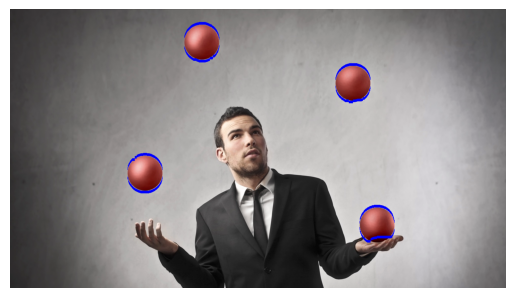

In [10]:
box_kernel = np.full((15,), 1)
mask_wide = cv2.dilate(mask, box_kernel)
mask_wide = mask_wide - mask

hue_new = np.where(mask_wide, 120, src_hsv[:,:,0])
sat_new = np.where(mask_wide, 255, src_hsv[:,:,1])
val_new = np.where(mask_wide, 255, src_hsv[:,:,2])

src_green = src_hsv.copy()
src_green[:,:,0] = hue_new
src_green[:,:,1] = sat_new
src_green[:,:,2] = val_new
display(cv2.cvtColor(src_green, cv2.COLOR_HSV2RGB))

# Homework

## Blob detection
Another topic related to morphological operations is blob detection.

The Simple Blob Detector operates by finding contours, and then aggregating centers of contoured shapes. Useful when you need the center coordinates of colourful objects.

In [11]:
src = cv2.imread('blobs.png')

#### What do the parameters mean? (5 points)
The following two snippets work, but not every blob is detected. Correct a few parameters so every blob is detected. Explain, why the ones you corrected matter.

If you want more docs, look at https://docs.opencv.org/3.4/d0/d7a/classcv_1_1SimpleBlobDetector.html

NB! the border drawn will always be circular, that's completely fine here.

In [16]:
blob_params = cv2.SimpleBlobDetector_Params()

blob_params.filterByColor = True #  is set to True and blob_params.blobColor is set to 0 to detect dark blobs on a light background.
blob_params.blobColor = 0 

blob_params.filterByArea = True
blob_params.maxArea = 31000 #14000 #This parameter specifies the maximum area in pixels that a blob can have to be detected. therefore it was adjusted (the value is not precise)

blob_params.filterByCircularity = False # is set to False to allow detection of blobs with varying circularity.
# If set to True, only perfectly circular blobs will be detected.
# Setting it to False allows for detection of blobs with irregular shapes.

blob_params.filterByConvexity = False # is set to False to allow detection of non-convex blobs.
# If set to True, only convex blobs will be detected.
# Setting it to False allows for detection of blobs with concave shapes.

blob_params.filterByInertia = False #  to allow detection of blobs with varying inertia.
# If set to True, only blobs with a specific level of elongation or orientation will be detected. 
# Setting it to False allows for detection of blobs with varying shapes and orientations.

detector = cv2.SimpleBlobDetector_create(blob_params)

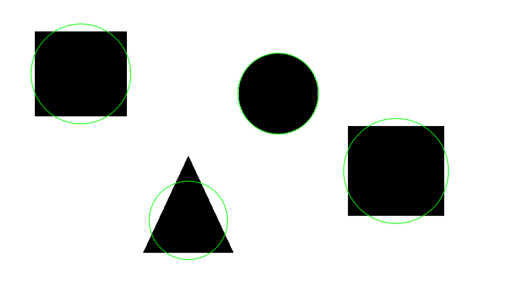

In [17]:
keypoints = detector.detect(src)

im_with_keypoints = cv2.drawKeypoints(src, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
display(im_with_keypoints)

#### My simple circle detector (15 points)
Remember pattern matching from lab 3? Use it alongside thresholding to try and detect the balls as accurately as you can.

*Hint: the mask lets us paint every ball the exact same color and use a picture of that as the pattern. Pattern is detected in output spots with the lowest/highest intensity, depending on the method.

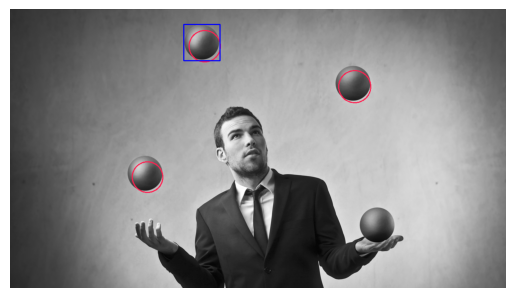

In [174]:
# src = cv2.imread("balls.jpg", cv2.IMREAD_GRAYSCALE)
# template = src[40:135, 455:550]

# if src is None:
#     print("Error: Failed to load image")
# else:
#     # Apply blob detection
#     params = cv2.SimpleBlobDetector_Params()
#     params.filterByArea = True
#     params.minArea = 100
#     params.filterByCircularity = False
#     params.filterByConvexity = False
#     params.filterByInertia = False
#     detector = cv2.SimpleBlobDetector_create(params)
#     keypoints = detector.detect(src)

#     src_with_keypoints = cv2.drawKeypoints(src, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#     result = cv2.matchTemplate(src, template, cv2.TM_CCOEFF_NORMED)
#     min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

#     x_start, y_start = max_loc
#     x_end = x_start + template.shape[1]
#     y_end = y_start + template.shape[0]

#     cv2.rectangle(src_with_keypoints, (x_start, y_start), (x_end, y_end), (0, 0, 255), 2)


src = cv2.imread("balls.jpg", cv2.IMREAD_GRAYSCALE)
template = src[40:135, 455:550]

if src is None:
    print("Error: Failed to load image")
else:
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 1500
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False
    params.thresholdStep = 15 
    params.minThreshold = 100 
    params.maxThreshold = 255 
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(src)

    src_with_keypoints = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

    for keypoint in keypoints:
        x, y = int(keypoint.pt[0]), int(keypoint.pt[1])
        cv2.circle(src_with_keypoints, (x, y), int(keypoint.size/2), (255, 32, 80), 2)

    result = cv2.matchTemplate(src, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    x_start, y_start = max_loc
    x_end = x_start + template.shape[1]
    y_end = y_start + template.shape[0]

    cv2.rectangle(src_with_keypoints, (x_start, y_start), (x_end, y_end), (0, 0, 255), 2)

#now check if both blob and match are detected => they are the balls then

#display (out[40:135, 455:550])
display (src_with_keypoints)

#### Math exercises (4 points each)
You have the following sets and access to dilation/erosion functions and logical operations.

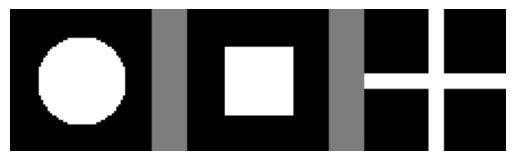

In [14]:
circle = np.where([[is_in_circle(x,y) for y in range(-32,32)] for x in range(-32,32)], 255, 0).astype(np.uint8)
square = np.where([[bool(abs(x)<16 and abs(y)<16) for y in range(-32,32)] for x in range(-32,32)], 255, 0).astype(np.uint8)
plus = np.where([[bool(abs(x)<4 or abs(y)<4) for y in range(-32,32)] for x in range(-32,32)], 255, 0).astype(np.uint8)

box_kernel = np.full((5,5),1).astype(np.uint8)
edge_kernel = np.zeros((11,11)).astype(np.uint8)
edge_kernel[0,0] = 1
edge_kernel[-1,0] = 1
edge_kernel[0,-1] = 1
edge_kernel[-1,-1] = 1
diag_kernel = np.array([[0,0,0,0,0,0,1],
                        [0,0,0,0,0,1,0],
                        [0,0,0,0,1,0,0],
                        [0,0,0,1,0,0,0],
                        [0,0,1,0,0,0,0],
                        [0,1,0,0,0,0,0],
                        [1,0,0,0,0,0,0]]).astype(np.uint8)

display(np.concatenate([circle, np.full((64,16),125), square, np.full((64,16),125), plus], axis=1))

Achieve and document the following outputs:

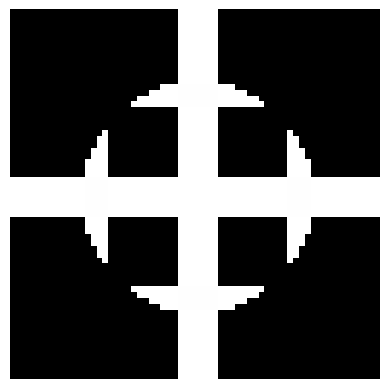
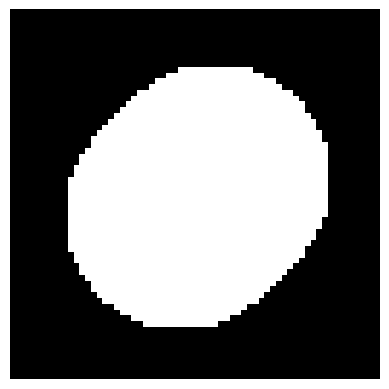
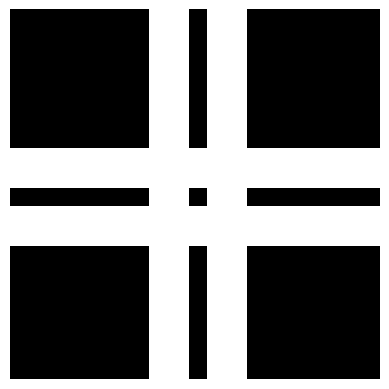
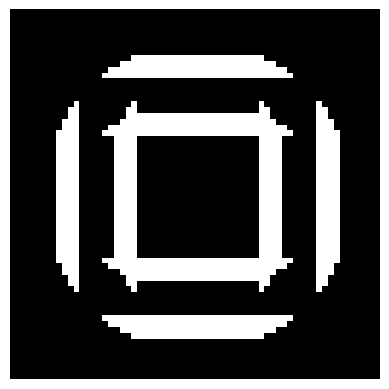
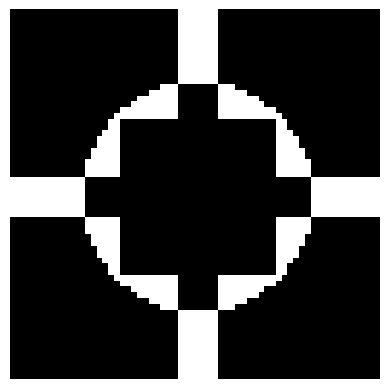
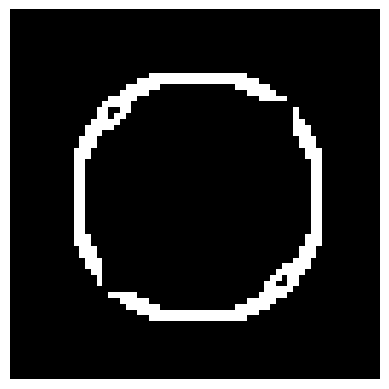

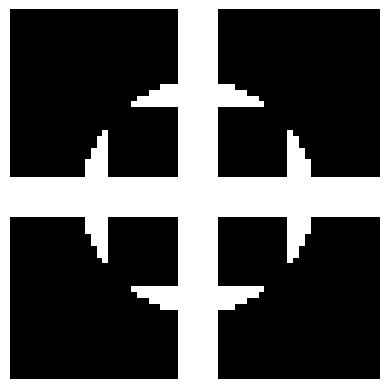

In [26]:
csp1 = np.zeros((64, 64), dtype=np.uint8)  # white circle bottom - black square mid and white plus on top
csp1 = cv2.bitwise_or(csp1, circle)
csp1 = cv2.bitwise_and(csp1, cv2.bitwise_not(square))
csp1 = cv2.bitwise_or(csp1, plus)
display (csp1)

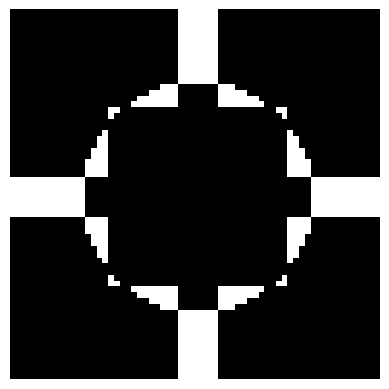

In [62]:
circle = np.where([[is_in_circle(x,y) for y in range(-32,32)] for x in range(-32,32)], 255, 0).astype(np.uint8)
square = np.where([[bool(abs(x)<16 and abs(y)<16) for y in range(-32,32)] for x in range(-32,32)], 255, 0).astype(np.uint8)
plus = np.where([[bool(abs(x)<4 or abs(y)<4) for y in range(-32,32)] for x in range(-32,32)], 255, 0).astype(np.uint8)

box_kernel = np.full((5,5),1).astype(np.uint8)
edge_kernel = np.zeros((11,11)).astype(np.uint8)
edge_kernel[0,0] = 1
edge_kernel[-1,0] = 1
edge_kernel[0,-1] = 1
edge_kernel[-1,-1] = 1
diag_kernel = np.array([[0,0,0,0,0,0,1],
                        [0,0,0,0,0,1,0],
                        [0,0,0,0,1,0,0],
                        [0,0,0,1,0,0,0],
                        [0,0,1,0,0,0,0],
                        [0,1,0,0,0,0,0],
                        [1,0,0,0,0,0,0]]).astype(np.uint8)



spc = np.zeros((64, 64), dtype=np.uint8)

spc = cv2.bitwise_or(spc, plus)
spc = cv2.bitwise_or(spc, square)
spc = cv2.bitwise_xor(spc, circle)

display(spc)

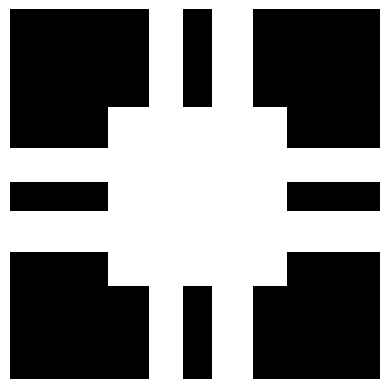

In [176]:
circle = np.where([[is_in_circle(x,y) for y in range(-32,32)] for x in range(-32,32)], 255, 0).astype(np.uint8)
square = np.where([[bool(abs(x)<16 and abs(y)<16) for y in range(-32,32)] for x in range(-32,32)], 255, 0).astype(np.uint8)
plus = np.where([[bool(abs(x)<4 or abs(y)<4) for y in range(-32,32)] for x in range(-32,32)], 255, 0).astype(np.uint8)

box_kernel = np.full((5,5),1).astype(np.uint8)
edge_kernel = np.zeros((11,11)).astype(np.uint8)
edge_kernel[0,0] = 1
edge_kernel[-1,0] = 1
edge_kernel[0,-1] = 1
edge_kernel[-1,-1] = 1
diag_kernel = np.array([[0,0,0,0,0,0,1],
                        [0,0,0,0,0,1,0],
                        [0,0,0,0,1,0,0],
                        [0,0,0,1,0,0,0],
                        [0,0,1,0,0,0,0],
                        [0,1,0,0,0,0,0],
                        [1,0,0,0,0,0,0]]).astype(np.uint8)
thickness = 12

sharp = np.zeros((64, 64), dtype=np.uint8)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (thickness, thickness))
dilated_plus = cv2.dilate(plus, kernel)

sharp = cv2.bitwise_or(sharp, dilated_plus)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded_plus = cv2.erode(plus, kernel)
sharp = cv2.bitwise_xor(sharp, eroded_plus)

square_coords = [thickness, square.shape[0] - thickness, thickness, square.shape[1] - thickness]

square_cropped = sharp[square_coords[0]:square_coords[1], square_coords[2]:square_coords[3]]

square_resized = cv2.resize(square_cropped, (int(square_cropped.shape[1] * 0.5), int(square_cropped.shape[0] * 0.5)), interpolation=cv2.INTER_NEAREST)

#sharp[square_coords[0]:square_coords[1], square_coords[2]:square_coords[3]] = cv2.bitwise_or(sharp[square_coords[0]:square_coords[1], square_coords[2]:square_coords[3]], square_resized)
sharp = cv2.bitwise_or(sharp, square)
display(sharp)